In [1]:
import os
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 300)

In [2]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_bollinger_band1(df):
    window=10
    wap_bol_upper = df["wap1"].rolling(window=window).mean() + (df["wap1"].rolling(window=window).std() * 2)
    wap_bol_lower = df["wap1"].rolling(window=window).mean() - (df["wap1"].rolling(window=window).std() * 2)
    wap_bol_balance = wap_bol_upper - wap_bol_lower
    return wap_bol_balance

def calc_bollinger_band2(df):
    window=10
    wap_bol_upper = df["wap2"].rolling(window=window).mean() + (df["wap2"].rolling(window=window).std() * 2)
    wap_bol_lower = df["wap2"].rolling(window=window).mean() - (df["wap2"].rolling(window=window).std() * 2)
    wap_bol_balance = wap_bol_upper - wap_bol_lower
    return wap_bol_balance

def calc_bollinger_band3(df):
    window=10
    wap_bol_upper = df["wap3"].rolling(window=window).mean() + (df["wap3"].rolling(window=window).std() * 2)
    wap_bol_lower = df["wap3"].rolling(window=window).mean() - (df["wap3"].rolling(window=window).std() * 2)
    wap_bol_balance = wap_bol_upper - wap_bol_lower
    return wap_bol_balance

def calc_bollinger_band4(df):
    window=10
    wap_bol_upper = df["wap4"].rolling(window=window).mean() + (df["wap4"].rolling(window=window).std() * 2)
    wap_bol_lower = df["wap4"].rolling(window=window).mean() - (df["wap4"].rolling(window=window).std() * 2)
    wap_bol_balance = wap_bol_upper - wap_bol_lower
    return wap_bol_balance

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    df['bollinger_band_balance1'] = calc_bollinger_band1(df)
    df['bollinger_band_balance2'] = calc_bollinger_band2(df)
    df['bollinger_band_balance3'] = calc_bollinger_band3(df)
    df['bollinger_band_balance4'] = calc_bollinger_band4(df)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return3': [np.sum, realized_volatility, np.mean, np.std],
        'log_return4': [np.sum, realized_volatility, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'bollinger_band_balance1':[np.sum, np.mean, np.std],
        'bollinger_band_balance2':[np.sum, np.mean, np.std],
        'bollinger_band_balance3':[np.sum, np.mean, np.std],
        'bollinger_band_balance4':[np.sum, np.mean, np.std],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)
    
    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_return1_realized_volatility_150', 'log_return1_realized_volatility_300', 'log_return1_realized_volatility_450', 
                'log_return2_realized_volatility', 'log_return2_realized_volatility_150', 'log_return2_realized_volatility_300', 'log_return2_realized_volatility_450', 
                'log_return3_realized_volatility', 'log_return3_realized_volatility_150', 'log_return3_realized_volatility_300', 'log_return3_realized_volatility_450', 
                'log_return4_realized_volatility', 'log_return4_realized_volatility_150', 'log_return4_realized_volatility_300', 'log_return4_realized_volatility_450',                 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_450', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_150']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate(train, test):
    # Hyperparammeters (optimized)
    seed = 42
    params = {
        'learning_rate': 0.13572437900113307,        
        'lambda_l1': 2.154360665259325,
        'lambda_l2': 6.711089761523827,
        'num_leaves': 769,
        'min_sum_hessian_in_leaf': 20.44437160769411,
        'feature_fraction': 0.7921473067441019,
        'feature_fraction_bynode': 0.8083803860191322,
        'bagging_fraction': 0.9726755660563261,
        'bagging_freq': 42,
        'min_data_in_leaf': 690,
        'max_depth': 3,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
    }   
    
    # Split features and target
    x = train.drop(['row_id', 'target', 'time_id'], axis = 1)
    y = train['target']
    x_test = test.drop(['row_id', 'time_id'], axis = 1)
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    x_test['stock_id'] = x_test['stock_id'].astype(int)
    
    evals_result = {}
    
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 66, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 10000, 
                          early_stopping_rounds = 67, 
                          verbose_eval = 200,
                          feval = feval_rmspe,
                          evals_result=evals_result)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        test_predictions += model.predict(x_test) / 5
        
        
        
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return test_predictions,model,evals_result

# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')
# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

# Traing and evaluate
test_predictions,model,evals_result = train_and_evaluate(train, test)
# Save test predictions
test['target'] = test_predictions
test[['row_id', 'target']].to_csv('submission.csv',index = False)

Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 27.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Training fold 1
Training until validation scores don't improve for 67 rounds
[200]	training's rmse: 0.000461343	training's RMSPE: 0.213674	valid_1's rmse: 0.000479409	valid_1's RMSPE: 0.221216
[400]	training's rmse: 0.000442579	training's RMSPE: 0.204983	valid_1's rmse: 0.000465731	valid_1's RMSPE: 0.214904
[600]	training's rmse: 0.0004303	training's RMSPE: 0.199296	valid_1's rmse: 0.000456109	valid_1's RMSPE: 0.210464
[800]	training's rmse: 0.000420514	training's RMSPE: 0.194764	valid_1's rmse: 0.000449858	valid_1's RMSPE: 0.20758
[1000]	training's rmse: 0.00041266	training's RMSPE: 0.191126	valid_1's rmse: 0.000445385	valid_1's RMSPE: 0.205516
[1200]	training's rmse: 0.000406288	training's RMSPE: 0.188175	valid_1's rmse: 0.00044177	valid_1's RMSPE: 0.203848
[1400]	training's rmse: 0.000400793	training's RMSPE: 0.18563	valid_1's rmse: 0.00043854	valid_1's RMSPE: 0.202358
[1600]	training's rmse: 0.00039575	training's RMSPE: 0.183294	valid_1's rmse: 0.000435723	valid_1's RMSPE: 0.201057

In [3]:
train.head()

,stock_id,time_id,target,row_id,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,log_return3_sum,log_return3_realized_volatility,log_return3_mean,log_return3_std,log_return4_sum,log_return4_realized_volatility,log_return4_mean,log_return4_std,price_spread_sum,price_spread_mean,price_spread_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,bollinger_band_balance1_sum,bollinger_band_balance1_mean,bollinger_band_balance1_std,bollinger_band_balance2_sum,bollinger_band_balance2_mean,bollinger_band_balance2_std,bollinger_band_balance3_sum,bollinger_band_balance3_mean,bollinger_band_balance3_std,bollinger_band_balance4_sum,bollinger_band_balance4_mean,bollinger_band_balance4_std,log_return1_sum_450,log_return1_realized_volatility_450,log_return1_mean_450,log_return1_std_450,log_return2_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,log_return3_sum_450,log_return3_realized_volatility_450,log_return3_mean_450,log_return3_std_450,log_return4_sum_450,log_return4_realized_volatility_450,log_return4_mean_450,log_return4_std_450,price_spread_sum_450,price_spread_mean_450,price_spread_std_450,bid_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,ask_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,bollinger_band_balance1_sum_450,bollinger_band_balance1_mean_450,bollinger_band_balance1_std_450,bollinger_band_balance2_sum_450,bollinger_band_balance2_mean_450,bollinger_band_balance2_std_450,bollinger_band_balance3_sum_450,bollinger_band_balance3_mean_450,bollinger_band_balance3_std_450,bollinger_band_balance4_sum_450,bollinger_band_balance4_mean_450,bollinger_band_balance4_std_450,log_return1_sum_300,log_return1_realized_volatility_300,log_return1_mean_300,log_return1_std_300,log_return2_sum_300,log_return2_realized_volatility_300,log_return2_mean_300,log_return2_std_300,log_return3_sum_300,log_return3_realized_volatility_300,log_return3_mean_300,log_return3_std_300,log_return4_sum_300,log_return4_realized_volatility_300,log_return4_mean_300,log_return4_std_300,price_spread_sum_300,price_spread_mean_300,price_spread_std_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,bollinger_band_balance1_sum_300,bollinger_band_balance1_mean_300,bollinger_band_balance1_std_300,bollinger_band_balance2_sum_300,bollinger_band_balance2_mean_300,bollinger_band_balance2_std_300,bollinger_band_balance3_sum_300,bollinger_band_balance3_mean_300,bollinger_band_balance3_std_300,bollinger_band_balance4_sum_300,bollinger_band_balance4_mean_300,bollinger_band_balance4_std_300,log_return1_sum_150,log_return1_realized_volatility_150,log_return1_mean_150,log_return1_std_150,log_return2_sum_150,log_return2_realized_volatility_150,log_return2_mean_150,log_return2_std_150,log_return3_sum_150,log_return3_realized_volatility_150,log_return3_mean_150,log_return3_std_150,log_return4_sum_150,log_return4_realized_volatility_150,log_return4_mean_150,log_return4_std_150,price_spread_sum_150,price_spread_mean_150,price_spread_std_150,bid_spread_sum_150,bid_spread_mean_150,bid_spread_std_150,ask_spread_sum_150,ask_spread_mean_150,ask_spread_std_150,bollinger_band_balance1_sum_150,bollinger_band_balance1_mean_150,bollinger_band_balance1_std_150,bollinger_band_balance2_sum_150,bollinger_band_balance2_mean_150,bollinger_band_balance2_std_150,bollinger_band_balance3_sum_150,bollinger_band_balance3_mean_150,bollinger_band_balance3_std_150,bollinger_band_balance4_sum_150,...,log_return1_realized_volatility_300_max_stock,log_return1_realized_volatility_300_min_stock,log_return1_realized_volatility_450_mean_stock,log_return1_realized_volatility_450_std_stock,log_return1_realized_volatility_450_max_stock,log_return1_realized_volatility_450_min_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_s

In [4]:
test.head()

,stock_id,time_id,row_id,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,log_return3_sum,log_return3_realized_volatility,log_return3_mean,log_return3_std,log_return4_sum,log_return4_realized_volatility,log_return4_mean,log_return4_std,price_spread_sum,price_spread_mean,price_spread_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,bollinger_band_balance1_sum,bollinger_band_balance1_mean,bollinger_band_balance1_std,bollinger_band_balance2_sum,bollinger_band_balance2_mean,bollinger_band_balance2_std,bollinger_band_balance3_sum,bollinger_band_balance3_mean,bollinger_band_balance3_std,bollinger_band_balance4_sum,bollinger_band_balance4_mean,bollinger_band_balance4_std,log_return1_sum_450,log_return1_realized_volatility_450,log_return1_mean_450,log_return1_std_450,log_return2_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,log_return3_sum_450,log_return3_realized_volatility_450,log_return3_mean_450,log_return3_std_450,log_return4_sum_450,log_return4_realized_volatility_450,log_return4_mean_450,log_return4_std_450,price_spread_sum_450,price_spread_mean_450,price_spread_std_450,bid_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,ask_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,bollinger_band_balance1_sum_450,bollinger_band_balance1_mean_450,bollinger_band_balance1_std_450,bollinger_band_balance2_sum_450,bollinger_band_balance2_mean_450,bollinger_band_balance2_std_450,bollinger_band_balance3_sum_450,bollinger_band_balance3_mean_450,bollinger_band_balance3_std_450,bollinger_band_balance4_sum_450,bollinger_band_balance4_mean_450,bollinger_band_balance4_std_450,log_return1_sum_300,log_return1_realized_volatility_300,log_return1_mean_300,log_return1_std_300,log_return2_sum_300,log_return2_realized_volatility_300,log_return2_mean_300,log_return2_std_300,log_return3_sum_300,log_return3_realized_volatility_300,log_return3_mean_300,log_return3_std_300,log_return4_sum_300,log_return4_realized_volatility_300,log_return4_mean_300,log_return4_std_300,price_spread_sum_300,price_spread_mean_300,price_spread_std_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,bollinger_band_balance1_sum_300,bollinger_band_balance1_mean_300,bollinger_band_balance1_std_300,bollinger_band_balance2_sum_300,bollinger_band_balance2_mean_300,bollinger_band_balance2_std_300,bollinger_band_balance3_sum_300,bollinger_band_balance3_mean_300,bollinger_band_balance3_std_300,bollinger_band_balance4_sum_300,bollinger_band_balance4_mean_300,bollinger_band_balance4_std_300,log_return1_sum_150,log_return1_realized_volatility_150,log_return1_mean_150,log_return1_std_150,log_return2_sum_150,log_return2_realized_volatility_150,log_return2_mean_150,log_return2_std_150,log_return3_sum_150,log_return3_realized_volatility_150,log_return3_mean_150,log_return3_std_150,log_return4_sum_150,log_return4_realized_volatility_150,log_return4_mean_150,log_return4_std_150,price_spread_sum_150,price_spread_mean_150,price_spread_std_150,bid_spread_sum_150,bid_spread_mean_150,bid_spread_std_150,ask_spread_sum_150,ask_spread_mean_150,ask_spread_std_150,bollinger_band_balance1_sum_150,bollinger_band_balance1_mean_150,bollinger_band_balance1_std_150,bollinger_band_balance2_sum_150,bollinger_band_balance2_mean_150,bollinger_band_balance2_std_150,bollinger_band_balance3_sum_150,bollinger_band_balance3_mean_150,bollinger_band_balance3_std_150,bollinger_band_balance4_sum_150,bollinger_band_balance4_mean_150,...,log_return1_realized_volatility_300_min_stock,log_return1_realized_volatility_450_mean_stock,log_return1_realized_volatility_450_std_stock,log_return1_realized_volatility_450_max_stock,log_return1_realized_volatility_450_min_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_std_stock,log_return2

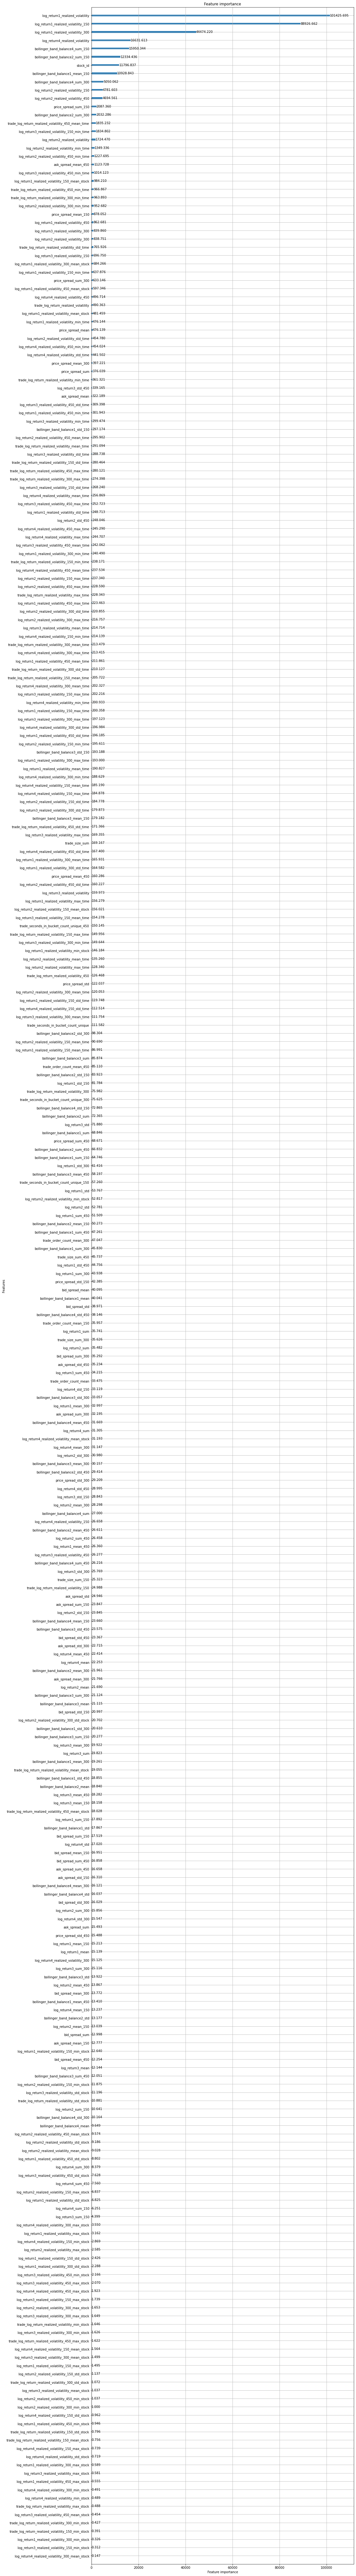

In [5]:
import matplotlib.pyplot as plt
fig,ax =plt.subplots(figsize=(15,150))
lgb.plot_importance(model,ax=ax,importance_type="gain")
plt.show()

In [7]:
evals_result['training'].keys()

odict_keys(['rmse', 'RMSPE'])

Plotting metrics recorded during training...


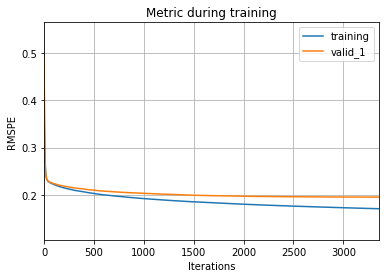

In [9]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='RMSPE')
plt.show()

Plotting metrics recorded during training...


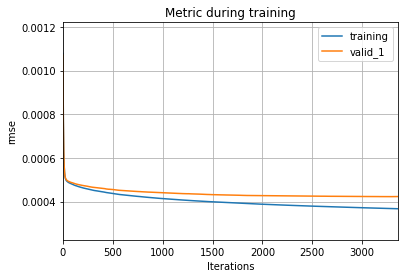

In [10]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

Plotting split value histogram...


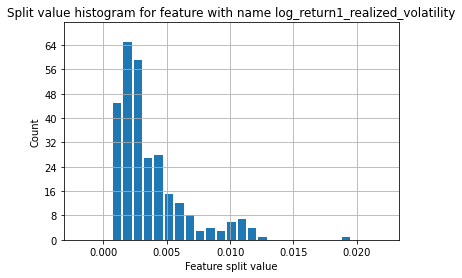

In [14]:
print('Plotting split value histogram...')
ax = lgb.plot_split_value_histogram(model, feature='log_return1_realized_volatility', bins='auto')
plt.show()

Plotting 54th tree...


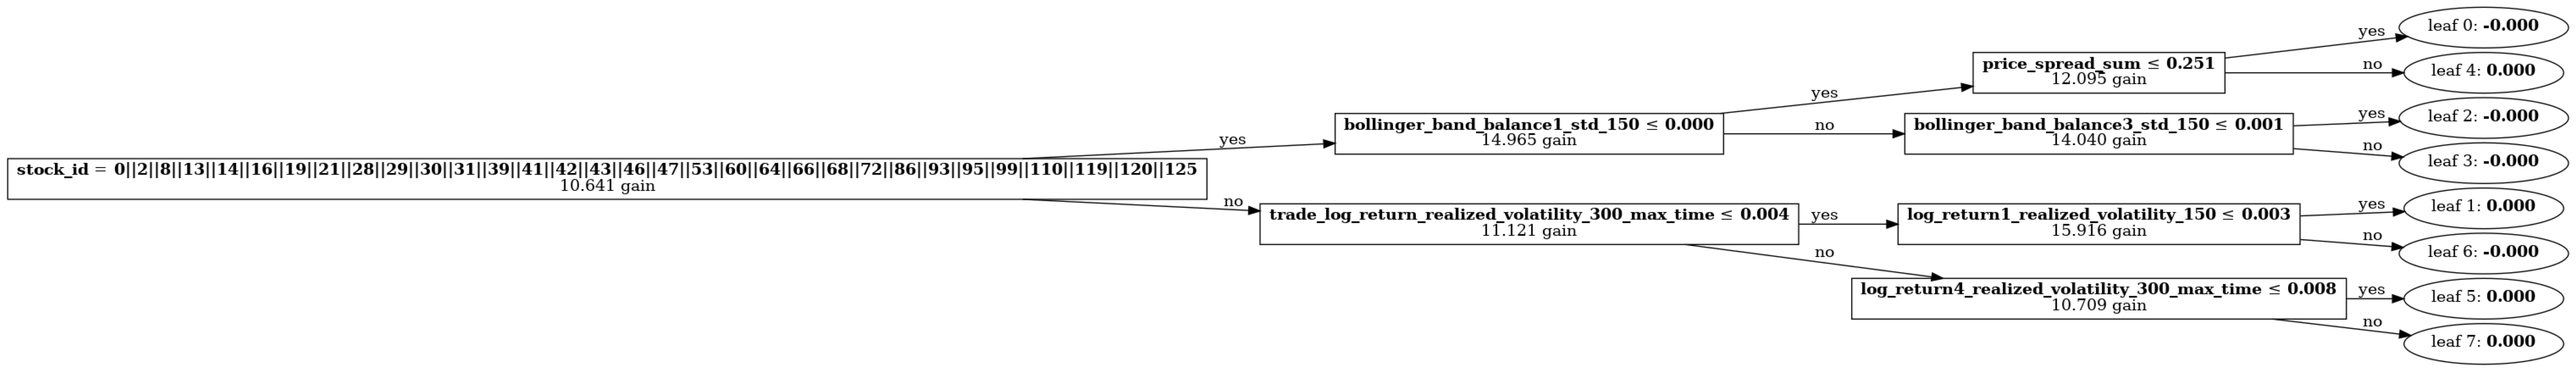

In [17]:

print('Plotting 54th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(model, tree_index=53, figsize=(100, 160), show_info=['split_gain'])
plt.show()


In [18]:
print('Plotting 54th tree with graphviz...')
graph = lgb.create_tree_digraph(model, tree_index=53, name='Tree54')
graph.render(view=True)

Plotting 54th tree with graphviz...


'Tree54.gv.pdf'